**Sentiment Analysis with BERT : This code is entirely written by @Nourchene**

As NLP keeps improving, a new model named BERT model is defined to allow us to pre-train a neural network on a large collection of texts, tweets, youtube comments etc... 


In [2]:
!pip install ktrain
!git clone https://github.com/nourchene-bargaoui/Kaggle_Dataset.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 60.1 MB/s 
     |████████████████████████████████| 981 kB 42.5 MB/s 
     |████████████████████████████████| 263 kB 40.1 MB/s 
     |████████████████████████████████| 3.8 MB 40.4 MB/s 
     |████████████████████████████████| 1.3 MB 50.6 MB/s 
     |████████████████████████████████| 468 kB 55.3 MB/s 
     |████████████████████████████████| 7.6 MB 41.4 MB/s 
     |████████████████████████████████| 880 kB 52.1 MB/s 
     |████████████████████████████████| 163 kB 50.1 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=786b8d201d469effaecdbbff47260378d94e7d4c910ceb8ace98fe42b5014f70
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=091441a2a46e222a6d5cdd

Get acces to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data**

Our corpus is a .json file from Kaggle including youtube comments extracted from youtube platform, as well as, tweets with #Youtube extracted from Twitter platform. Each of the documents can be found in our github repository : https://github.com/nourchene-bargaoui/Kaggle_Dataset.git (We already did a git clone to it)
 We'll try to build a model that can predict the sentiment from the comments.


In [4]:
CORPUS_PATH = "/content/Kaggle_Dataset/comments.ndjson.json"

In [5]:
pip install ndjson


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's visualize our dataset

In [6]:
import pandas as pd

In [7]:
comments = pd.read_csv('https://raw.githubusercontent.com/nourchene-bargaoui/Kaggle_Dataset/main/comments.csv', error_bad_lines=False)
videos = pd.read_csv('https://raw.githubusercontent.com/nourchene-bargaoui/Kaggle_Dataset/main/videos-stats.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
videos.head()

,Unnamed: 0,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407.0,672.0,135612.0
1,1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779.0,4306.0,1758063.0
2,2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825.0,3338.0,1564007.0
3,3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,2022-08-23,tech,71566.0,1426.0,922918.0
4,4,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513.0,5155.0,1855644.0


In [9]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1881 non-null   int64  
 1   Title         1881 non-null   object 
 2   Video ID      1881 non-null   object 
 3   Published At  1881 non-null   object 
 4   Keyword       1881 non-null   object 
 5   Likes         1879 non-null   float64
 6   Comments      1879 non-null   float64
 7   Views         1879 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 117.7+ KB


In [10]:
comments.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


In [11]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18409 entries, 0 to 18408
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  18409 non-null  int64  
 1   Video ID    18409 non-null  object 
 2   Comment     18408 non-null  object 
 3   Likes       18409 non-null  float64
 4   Sentiment   18409 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 719.2+ KB


**Split data**

Split data into train, dev, test 

In [12]:
import ndjson
from sklearn.model_selection import train_test_split

with open(CORPUS_PATH) as i:
    data = ndjson.load(i)
    
texts = [" ".join([doc["Video ID"], doc["Comment"]]) for doc in data]
labels = [doc["Sentiment"] for doc in data]
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 810
Dev size: 90
Test size: 100


Next, we need to determine the number of labels in our data. We'll map each of these labels to an index. In our sentiment analysis, there are three labels: 0 rating, 1 rating and 2 rating.

In [13]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'1.0': 0, '2.0': 1, '0.0': 2}


**BERT**

Now we move to the main part : BERT 
We will use a Python library, transformers, with implementations of an impressive number of transfer-learning models in PyTorch and Tensorflow. This makes fine adjustment of these models quite easy.

In [14]:
!pip install transformers
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We'll let PyTorch determine whether a GPU is available.

In [15]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Initializing a model**

Google has made available a range of BERT models for us to experiment with. For English, there is a choice between three models: bert-large-uncased is the largest model that will likely give the best results. Its smaller siblings are bert-base-uncased and bert-base-cased, which are more practical to work with. 
For Chinese there is bert-base-chinese, and for the other languages we have bert-base-multilingual-uncased and bert-base-multilingual-cased.

Uncased means that the training text has been lowercased and accents have been stripped. This is usually better, unless you know that case information is important for your task, such as with Named Entity Recognition.

In our example, we're going to investigate sentiment analysis on English. We'll therefore use the English BERT-base model.

In [16]:
BERT_MODEL = "bert-base-uncased"

Each model comes with its own tokenizer. This tokenizer splits texts into word pieces. In addition, we'll tell the tokenizer it should lowercase the text, as we're going to work with the uncased model.

In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Now, we need establish a model architecture. For this we mostly took an example out of the "hugging face" examples called BertForSequenceClassification. The output of a sequence classification model, where we have just one prediction for every sequence (positive or negative). As we're looking at sentiment classification, we're going to use the pretrained BERT model with a final layer for sequence classification on top.

In [18]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx), return_dict=False)
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem object, which contains all the information BERT needs:

- **a list of input ids.** Take a look at the logging output to see what this means. Every text has been split up into subword units, which are shared between all the languages in the multilingual model. When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. Note also the first [CLS] token. This token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.

- **the input mask:** the input mask tells the model which parts of the input it should look at and which parts it should ignore. In our example, we have made sure that every text has a length of 100 tokens. This means that some texts will be cut off after 100 tokens, while others will have to be padded with extra tokens. In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task.

- **the segment_ids:** some NLP task take several sequences as input. This is the case for question answering, natural language inference, etc. In this case, the segment ids tell BERT which sequence every token belongs to. In a text classification task like ours, however, there's only one segment, so all the input tokens receive segment id 0.

- **the label id:** the id of the label for this document.

In [19]:
import logging
import numpy as np

In [20]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [21]:
def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


In [22]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

The function evaluate is inspired from the Hugging Face website for Transformers : https://huggingface.co/docs/transformers/v4.22.2/en/training#evaluate

In [23]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            # define a new function named logits to compute loss values
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)
        
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
       
        #predicted_labels.append(outputs)
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

**Training**

Now it's time to start training. We're going to use:

- **AdamW optimizer** with a base learning rate of 5e-5, and train for a maximum of 100 epochs. Here are some additional things to note:

- **Gradient Accumulation** allows us to keep our batches small enough to fit into the memory of our GPU, while getting the advantages of using larger batch sizes. In practice, it means we sum the gradients of several batches, before we perform a step of gradient descent.

- **get_linear_schedule_with_warmup** to vary our learning rate during the training process. First, we're going to start with a small learning rate, which increases linearly during the warmup stage. Afterwards it slowly decreases again.

In [24]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps = num_train_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps (we call this number our patience). Whenever the development loss of our model improves, we save it.

I also used a Hugging Face tutorial link that shows how to implement some functions that I needed https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Optimize_Hugging_Face_models_with_Weights_%26_Biases.ipynb

In [25]:
import torch
import os
from tqdm import trange
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(dev_loss)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6310763309399287


Epoch:  33%|███▎      | 1/3 [12:38<25:17, 758.55s/it]

Training iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  67%|██████▋   | 2/3 [25:06<12:32, 752.57s/it]

Loss history: [0.6310763309399287]
Dev loss: 0.6833234330018362


Training iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  67%|██████▋   | 2/3 [37:44<18:52, 1132.43s/it]

Loss history: [0.6310763309399287, 0.6833234330018362]
Dev loss: 0.762764240304629
No improvement on development set. Finish training.


**Evaluation**

Let's now evaluate the model on some documents it has never seen. We'll load our best model and have it predict the labels for all documents in our data. We'll compute its precision, recall and F-score for the training, development and test set and print a full classification report for the test set.

In [26]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names), return_dict=False)
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

Evaluation iteration:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/7 [00:00<?, ?it/s]

Training performance: (0.8012345679012346, 0.8012345679012346, 0.8012345679012347, None)
Development performance: (0.7777777777777778, 0.7777777777777778, 0.7777777777777778, None)
Test performance: (0.67, 0.67, 0.67, None)
              precision    recall  f1-score   support

         1.0       0.54      0.66      0.59        32
         2.0       0.76      0.78      0.77        49
         0.0       0.73      0.42      0.53        19

    accuracy                           0.67       100
   macro avg       0.68      0.62      0.63       100
weighted avg       0.68      0.67      0.67       100



**Discussion** 

We can see that BERT obtains an accuracy of around 70% on the test data

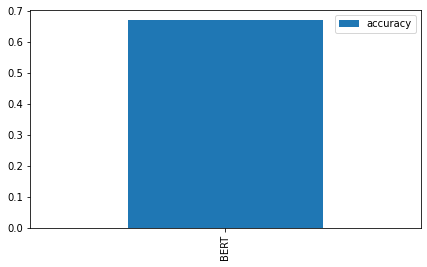

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")